In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
sys.path.append("../")
from sklearn.metrics import roc_auc_score
from src.data.cxr import build_cxr_dp, get_cxr_activations

/home/ksaab/miniconda3/envs/mlhc/lib/python3.9/site-packages/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


In [4]:
# Get a meerkat DataPanel with the data.
dp = build_cxr_dp(
        root_dir="/media/nvme_data/siim",
        segmentation=True,
        augmentation=False,
        detection=False,
    )
len(dp)

12047

In [5]:
test_dp = dp.lz[dp["split"]=="test"]
len(test_dp)

1000

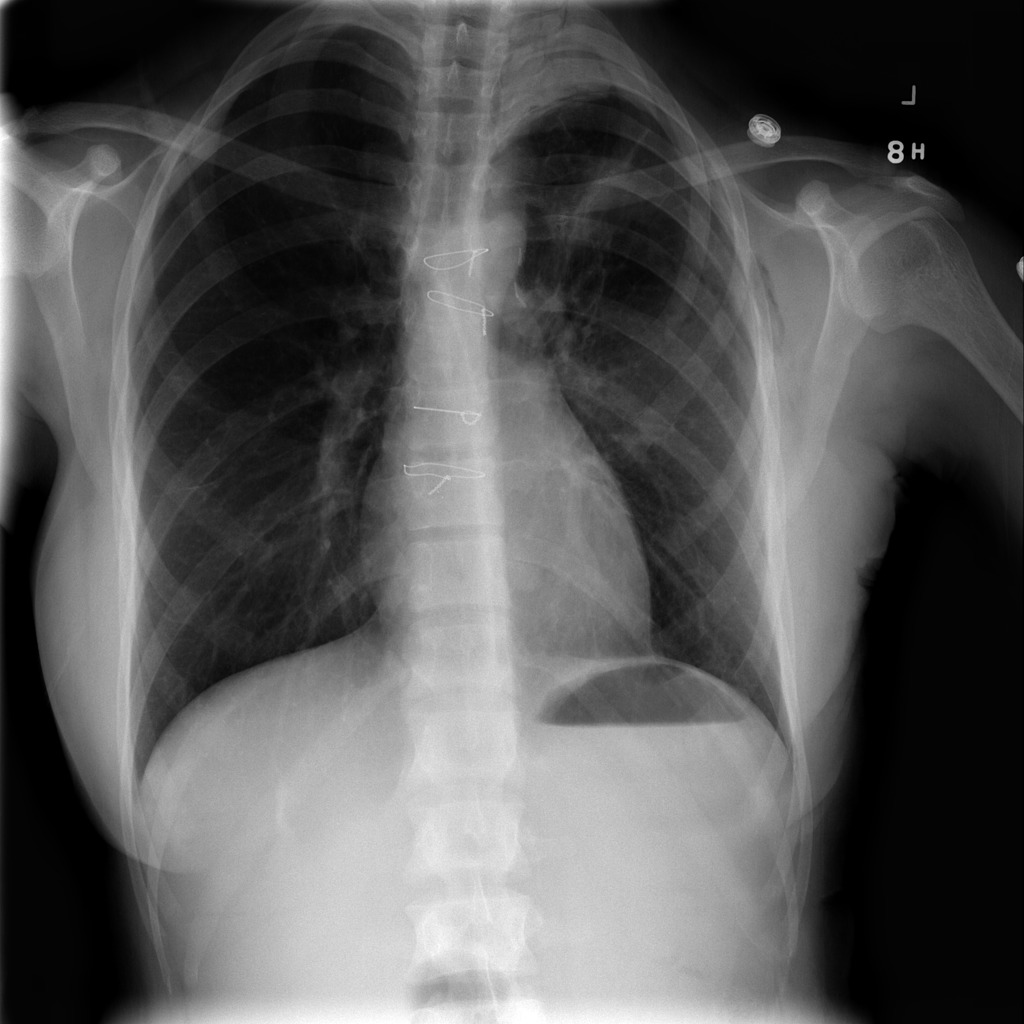

In [6]:
mask = (dp["chest_tube"]==0) & (dp["target"]==1)
dp_ = dp.lz[mask]
dp_["img"][0]

In [9]:
def evaluate_robustness(model_pth, segmentation=True, bs=16, device=0):

    test_dp_ = get_cxr_activations(dp=test_dp, model_pth=model_pth, segmentation=segmentation, batch_size=bs,device=device)

    test_probs = test_dp_["output"].data[:,1] 

    test_labels = test_dp_["target"].data
    tubes_mask = np.array(test_dp["chest_tube"] == 1)
    notubes_mask = np.array(test_dp["chest_tube"] == 0)

    overall_score = roc_auc_score(test_labels,test_probs)

    neg_mask = np.array(test_labels == 0)
    pos_mask = np.array(test_labels == 1)
    tube_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,tubes_mask))
    notube_in_pos_mask = np.logical_or(neg_mask,np.logical_and(pos_mask,notubes_mask))

    tube_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,tubes_mask))
    notube_in_neg_mask = np.logical_or(pos_mask,np.logical_and(neg_mask,notubes_mask))

    mask = np.logical_or(np.logical_and(pos_mask,notubes_mask), np.logical_and(neg_mask,tubes_mask))
    robust_score = roc_auc_score(test_labels[mask],test_probs[mask])

    return (overall_score, robust_score)

In [10]:
# segmentation model
model_pth = "/home/ksaab/Documents/domino/scratch/khaled/results/method_seg/gaze_split_False/lr_0.0005/wd_0/dropout_0/cw_0.0/seed_123/domino/3u2avle5/checkpoints/epoch=9-step=2740.ckpt"


(overall_score, robust_score) = evaluate_robustness(model_pth, segmentation=True, bs=4, device=0)
print(f"Overall AUROC (pmx): {overall_score:.4f}")
print(f"Robust AUROC: {robust_score:.3f}")

  0%|          | 0/250 [00:00<?, ?it/s]

Overall AUROC (pmx): 0.8936
Robust AUROC: 0.822
